# Krigging

In [54]:
from all_imports import *

import _modules

%matplotlib inline
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

from pykrige.rk import RegressionKriging
import datetime as dt

from _modules.plotColors import *
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter, DayLocator

file_name: str = "_00-Krigging"
filepath_dir: str =os.path.join(r"C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report", file_name)

### Preprocessing

In [55]:
# -------------------------------------------------------------------------------------------
# Load the weather data into a coherent dataframe for each environmental variable
#
# -------------------------------------------------------------------------------------------

def LoadWeatherStationDataIntoDf(item: str, dirs: List[str] = []) -> pd.DataFrame:

    df_list = []
    for file_dir in dirs:
        filepaths, filenames = _modules.find_files_in_directory(file_dir, 'csv')
        
        for weather_file in filepaths:
            #print(weather_file)
            filename = os.path.basename(weather_file)
            station_name = filename.split('_')[1]
            df = pd.read_csv(weather_file)
            df = df[['Datetime', item]]
            df.rename(columns={item: f"{station_name}_{item}"}, inplace=True)

            df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%dT%H:%M:%S')
            df = df.drop_duplicates('Datetime') #Sure?
            df.set_index('Datetime', inplace=True)
            
            df_list.append(df)

    combined_df = pd.concat(df_list, axis=1, join='outer')
    combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
    return combined_df


dirs = [r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202402\EveryMinute',
        r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202403\EveryMinute']

WS_Temp_df = LoadWeatherStationDataIntoDf('AirTemp Ave (C)', dirs)
WS_relH_df = LoadWeatherStationDataIntoDf('RelHum Ave (%)', dirs)
WS_Rad_df = LoadWeatherStationDataIntoDf('GlobalRad Ave (W/m2)', dirs)
# WS_Wspeed_df = LoadWeatherStationDataIntoDf('RelHum Ave (%)', dirs)
# WS_WDir_df = LoadWeatherStationDataIntoDf('RelHum Ave (%)', dirs)

start_date = '2024-01-01'
end_date = '2024-03-15'
WS_Temp_filtered_df = WS_Temp_df.loc[start_date:end_date]

#display(WS_Temp_filtered_df.columns)


C:\Users\gottk\AppData\Local\Temp\ipykernel_16304\208243368.py:27: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\gottk\AppData\Local\Temp\ipykernel_16304\208243368.py:27: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\gottk\AppData\Local\Temp\ipykernel_16304\208243368.py:27: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [56]:
# -------------------------------------------------------------------------------------------
# Load the weather station data and adjust it to meters and compute the relevenant features
#
# -------------------------------------------------------------------------------------------

from pyproj import Proj, transform
from scipy.spatial.distance import cdist

parent_dir: str = 'C:/Users/gottk/OneDrive/GITHUB/calma-esse-heat-stress-internal/Esse/data/krigging/'
dirOut: str = r'Esse\report\krigging_output'

griddf = pd.read_csv(parent_dir + '5mGrid_features_original.csv').fillna(0)

WS_df = pd.read_csv(os.path.join(parent_dir, 'WS_features_updated.csv'))
wgs84 = Proj(init='epsg:4326') 
utm = Proj(init='epsg:3414')   

def convert_to_meters(lon, lat):
    x, y = transform(wgs84, utm, lon, lat)
    return x, y

WS_df['X'], WS_df['Y'] = convert_to_meters(WS_df['Lon'], WS_df['Lat'])


def add_closest_grid_info(WS_df, griddf, columns=['distToTree', 'distToCarpark']):
    distances = cdist(WS_df[['X', 'Y']], griddf[['X', 'Y']])
    
    closest_indices = np.argmin(distances, axis=1)
    
    closest_info = griddf.iloc[closest_indices][columns].reset_index(drop=True)
    
    closest_info['reference'] = closest_indices
    
    WS_df = pd.concat([WS_df.reset_index(drop=True), closest_info], axis=1)
    
    return WS_df, closest_indices.tolist()

def add_closest_grid_info_multiple(WS_df, griddf, columns=['distToTree', 'distToCarpark'], num_closest=5):
    distances = cdist(WS_df[['X', 'Y']], griddf[['X', 'Y']])
    
    closest_indices = np.argsort(distances, axis=1)[:, :num_closest]
    
    averaged_values = {col: [] for col in columns}
    
    for indices in closest_indices:
        closest_data = griddf.iloc[indices][columns]
        for col in columns:
            averaged_values[col].append(closest_data[col].mean())
    
    averaged_info = pd.DataFrame(averaged_values)
    
    WS_df = pd.concat([WS_df.reset_index(drop=True), averaged_info], axis=1)
    unique_reference_values = np.unique(closest_indices.flatten()).tolist()
    return WS_df, unique_reference_values

selection = ['distToTree', 'distToCarpark', 'distToCourtTrack', 'distToPath', 'distToRoad', 'distToWalkway', 'Sun_h', 'Bld_SkyEx', 'Veg_SkyEx', 'Veg_height', 'Veg_percent', 'Bld_percent', 'Bld_height', 'Ter_height']
modified_WS_df, reference_values = add_closest_grid_info_multiple(WS_df, griddf, columns=selection, num_closest=5)

print(reference_values)
# display(WS_df.head(10))
# display(griddf.head(10))

selected_rows = griddf.loc[reference_values]
new_df = pd.DataFrame(selected_rows)
def convert_to_lon_lat(x, y):
    lon, lat = transform(utm, wgs84, x, y)
    return lon, lat


new_df['Lon'], new_df['Lat'] = convert_to_lon_lat(new_df['X'], new_df['Y'])
griddf['Lon'], griddf['Lat'] = convert_to_lon_lat(griddf['X'], griddf['Y'])

#display(modified_WS_df.head(5))
print(modified_WS_df.columns)

terrain_features  = ['Ter_height']
sky_features      = ['Sun_h', 'Bld_SkyEx', 'Veg_SkyEx']
bld_features      = ['Bld_percent', 'Bld_height']
veg_features      = ['Veg_height', 'Veg_percent']
distance_features = ['distToTree', 'distToWalkway', 'distToRoad',  'distToPath', 'distToCourtTrack', 'distToCarpark'] #'distToBuilding'

features = distance_features + sky_features   + veg_features  + bld_features + terrain_features

kriging_ws_df = modified_WS_df[features]

c:\Users\gottk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\gottk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

C:\Users\gottk\AppData\Local\Temp\ipykernel_16304\1790130720.py:19: FutureWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1



[1191, 1192, 1229, 8993, 8994, 9032, 9033, 9069, 10509, 10510, 10536, 10537, 10563, 10610, 10611, 10637, 10638, 10665, 11459, 11470, 11471, 11483, 11484, 11619, 11620, 11627, 11628, 12914, 19006, 19007, 19008, 19121, 19122, 20097, 20133, 20194, 20195, 20230, 20231, 20292, 20293, 20328, 20329, 21708, 21777, 21778, 21779, 21846, 22115, 22116, 22181, 22182, 22252, 23135, 23184, 23185, 23186, 23236, 26304, 26343, 26344, 26382, 26383, 27091, 27092, 27142, 27143, 27194, 27386, 27450, 27451, 27528, 27529, 28569, 28570, 28571, 28659, 28660, 28813, 28814, 28815, 28905, 28906, 29381, 29473, 29474, 29475, 29565, 30229, 30230, 30295, 30296, 30297, 32835, 32938, 32939, 32940, 33044, 33234, 33344, 33345, 33346, 33457, 33575, 33690, 33691, 33692, 33715, 33716, 33808, 33817, 33818, 33819, 33831, 33832, 33833, 33934, 33935, 34384, 34385, 34498, 34499, 34613, 34923, 34924, 35034, 35035, 35036, 37807, 38357, 38358, 38401, 38402, 38433, 38434, 38477, 38478, 38479, 38508, 39059, 39060, 39100, 39101, 39138,

C:\Users\gottk\AppData\Local\Temp\ipykernel_16304\1790130720.py:66: FutureWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

C:\Users\gottk\AppData\Local\Temp\ipykernel_16304\1790130720.py:66: FutureWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1



In [57]:
# -------------------------------------------------------------------------------------------
# Display the gridcells and waether stations
#
# -------------------------------------------------------------------------------------------
#TODO ADJUST THIS PLOT LATER FOR PRESENTATION

fig = go.Figure()

# Add WS_df markers in blue
fig.add_trace(
    go.Scattermapbox(
        lat=WS_df['Lat'],
        lon=WS_df['Lon'],
        mode='markers',
        marker=dict(
            size=4,
            color='blue',
            opacity=0.7
        ),
        name='WS_df'
    )
)

# Add new_df markers in red (larger) with square symbol
fig.add_trace(
    go.Scattermapbox(
        lat=griddf['Lat'],
        lon=griddf['Lon'],
        mode='markers',
        marker=dict(
            size=3,
            color='grey',
            opacity=0.7
        ),
        name='grid_df'
    )
)

# Highlight specified indices in red
fig.add_trace(
    go.Scattermapbox(
        lat=griddf.loc[reference_values, 'Lat'],
        lon=griddf.loc[reference_values, 'Lon'],
        mode='markers',
        marker=dict(
            size=4,
            symbol='circle', 
            color='red',
            opacity=0.7,
        ),
        name='highlighted_points'
    )
)


fig.update_layout(
    mapbox=dict(
        style="carto-positron",  # Set the style to "carto-positron" for grey
        center=go.layout.mapbox.Center(
            lat=griddf['Lat'].mean(),  # Center the map on mean latitude
            lon=griddf['Lon'].mean(),  # Center the map on mean longitude
        ),
        zoom=14,  # Adjust the zoom level as needed
    ),
    legend=dict(
        title="Region Status",
    ),
    width=800,  # Adjust the width of the plot
    height=800,  # Adjust the height of the plot
    title="Referenced Location Points taken for WS df definitions",
)

fig.show()
#--------------------------------------------------------------


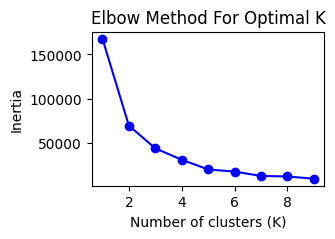

Cluster  Bld_percent_min  Bld_percent_max  Bld_percent_mean  \
0        0         0.000000         0.000000          0.000000   
1        1         0.000000         5.474783          0.557870   
2        2         3.513083        52.015696         23.592887   
3        3         0.000000        34.938296          2.915190   
4        4        99.757373       100.000000         99.878687   

   Veg_percent_min  Veg_percent_max  Veg_percent_mean  Bld_SkyEx_min  \
0         0.000000        48.610781         18.340391       0.662165   
1         0.000000        14.109461          1.417642      66.122865   
2         0.000000         0.000000          0.000000      48.232014   
3        55.684077       100.000000         86.369434       0.000000   
4         0.000000         0.000000          0.000000      50.036723   

   Bld_SkyEx_max  Bld_SkyEx_mean  Veg_SkyEx_min  Veg_SkyEx_max  \
0      36.140558       12.296695      58.131688      85.374782   
1      90.641306       79.218697      53.791962      89.526386   
2      81.119623       65.944602       2.899949      51.763680   
3      40.094959       14.690335      69.248286      97.782275   
4      86.688316       68.362520       0.000000       6.516523   

   Veg_SkyEx_mean  Sun_h_min  Sun_h_max  Sun_h_mean  
0       70.259417        0.0        5.6    1.628571  
1       73.251470        7.4       11.0   10.200000  
2       26.046424        7.6       12.0   10.566667  
3       84.407292        0.0        7.0    2.100000  
4        3.258261        8.6       11.2    9.900000

In [58]:
# -------------------------------------------------------------------------------------------
# Cluster the Weather stations by common features, redescribe them and make plots
#
# -------------------------------------------------------------------------------------------

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df = modified_WS_df.copy()

features = df[['Bld_percent', 'Veg_percent', 'Bld_SkyEx', 'Veg_SkyEx', 'Sun_h']]

# Determine the optimal number of clusters using the Elbow Method
inertia = []
K = range(1, 10)  # Range of number of clusters to try
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(features)
    inertia.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(3, 2))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

# Based on the elbow plot, choose the optimal number of clusters
optimal_k = 5  # Replace this with the optimal number of clusters determined from the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(features)

# Add the cluster labels to the original dataframe
df['Cluster'] = kmeans.labels_
withCluster_WS_df = df.copy()

fig_clustered = go.Figure()
# Create a color palette for clusters
palette = px.colors.qualitative.Plotly

# Add scatter mapbox traces for each cluster
for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    fig_clustered.add_trace(
        go.Scattermapbox(
            lat=cluster_data['Lat'],
            lon=cluster_data['Lon'],
            mode='markers',
            marker=dict(
                size=8,
                color=palette[cluster],  # Use color from the palette
                opacity=0.7
            ),
            name=f'Cluster {cluster}'
        )
    )


fig_clustered.update_layout(
    mapbox_style="carto-positron",
    margin={"r":0,"t":40,"l":0,"b":0},
    height=600,
    mapbox=dict(
        center=go.layout.mapbox.Center(
            lat=df['Lat'].mean(),
            lon=df['Lon'].mean()
        ),
        zoom=14
    ),
    title="Geographical Clustering of Weather Stations"
)

fig_clustered.show()

# -------------------------------------------------------------------------------------------
# Describe the cluster features
#
# -------------------------------------------------------------------------------------------
aggregation_functions = {feature: ['min', 'max', 'mean'] for feature in features.columns}
cluster_stats = df.groupby('Cluster').agg(aggregation_functions)

# Flatten the MultiIndex columns and create new column names
cluster_stats.columns = ['_'.join(col).strip() for col in cluster_stats.columns.values]

# Reset index to turn the grouped DataFrame back into a regular DataFrame
cluster_stats.reset_index(inplace=True)

display(cluster_stats)

#add a column with renamed clusters


### Air Temperature

In [65]:
def plot_weather_station_data(WS_Temp_df, filepath_dir, Name, highlightColor, minimum, maximum):
    # Resample data to 1-hour intervals and calculate mean
    df = WS_Temp_df.resample('1H').mean()

    # Calculating min, max, and mean values for each hour
    min_values = df.min(axis=1)
    max_values = df.max(axis=1)
    mean_values = df.mean(axis=1)

    # Creating a new DataFrame with these values
    stats_df = pd.DataFrame({
        'Time': df.index,
        'Min': min_values,
        'Max': max_values,
        'Mean': mean_values
    })

    # Resample data by day to get daily mean
    daily_mean_values = WS_Temp_df.resample('D').mean().mean(axis=1)

    # Plotting the data
    plt.figure(figsize=(14, 6))

    # Shading the area between min and max
    plt.fill_between(stats_df['Time'], stats_df['Min'], stats_df['Max'], color='grey', alpha=0.5, label='Min-Max Range', linewidth=0.01)

    plt.axvspan(pd.Timestamp('2024-01-18'), pd.Timestamp('2024-02-07'), color='grey', alpha=0.15, label='Study Period')

    plt.axvspan(pd.Timestamp('2024-02-20'), pd.Timestamp('2024-03-15'), color='grey', alpha=0.15, label='Study Period')

    # Plotting the mean values as a thin red line
    sns.lineplot(data=stats_df, x='Time', y='Mean', color=highlightColor, label='Mean (Hourly)', linewidth=1)

    # Plotting the daily mean values as a black line
    sns.lineplot(x=daily_mean_values.index, y=daily_mean_values, color='black', label='Mean (Daily)', linewidth=1)

    # Setting y-axis limits
    plt.ylim(minimum, maximum)

    # Formatting the x-axis to show dates in DD.MM format
    plt.gca().xaxis.set_major_formatter(DateFormatter("%d.%m"))
    plt.gca().xaxis.set_major_locator(DayLocator(interval=3))

    # Removing the top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title('Weather Station Data: Min, Max, and Mean')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()

    # Saving the plot
    if filepath_dir:
        filepath = os.path.join(filepath_dir, Name)
        directory = os.path.dirname(filepath)
        
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {filepath}")

    plt.show()



Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\Linechart_AirTemperature.png


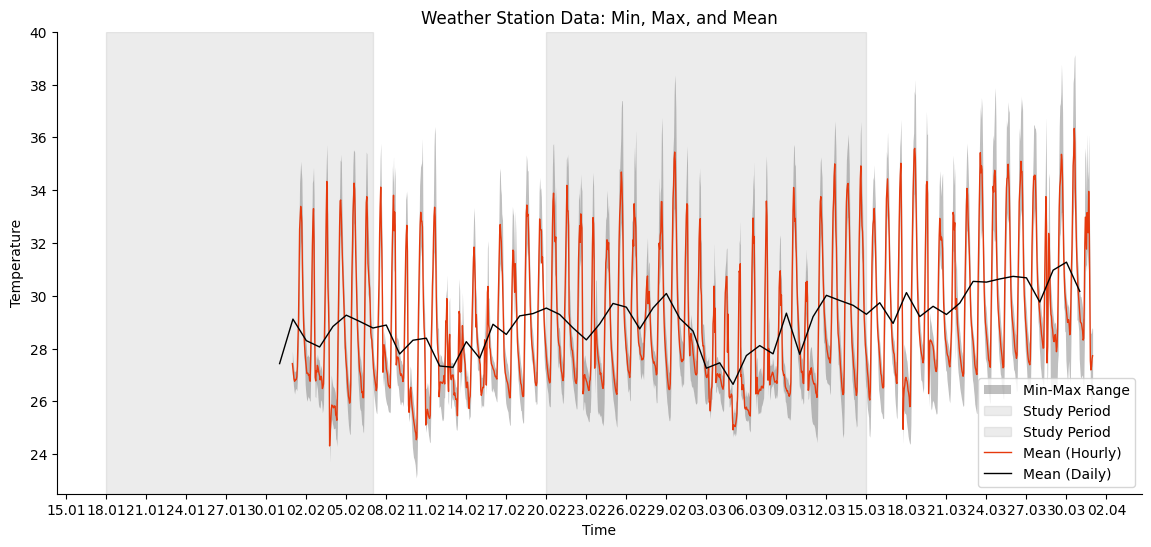

Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\Linechart_RelHumidity.png


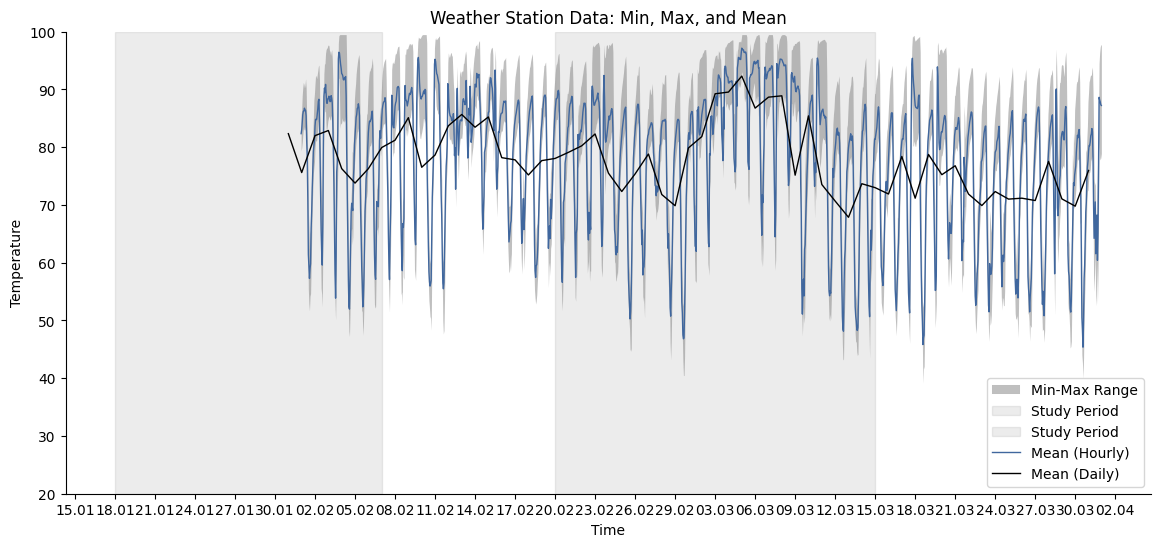

Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\Linechart_RelHumidity.png


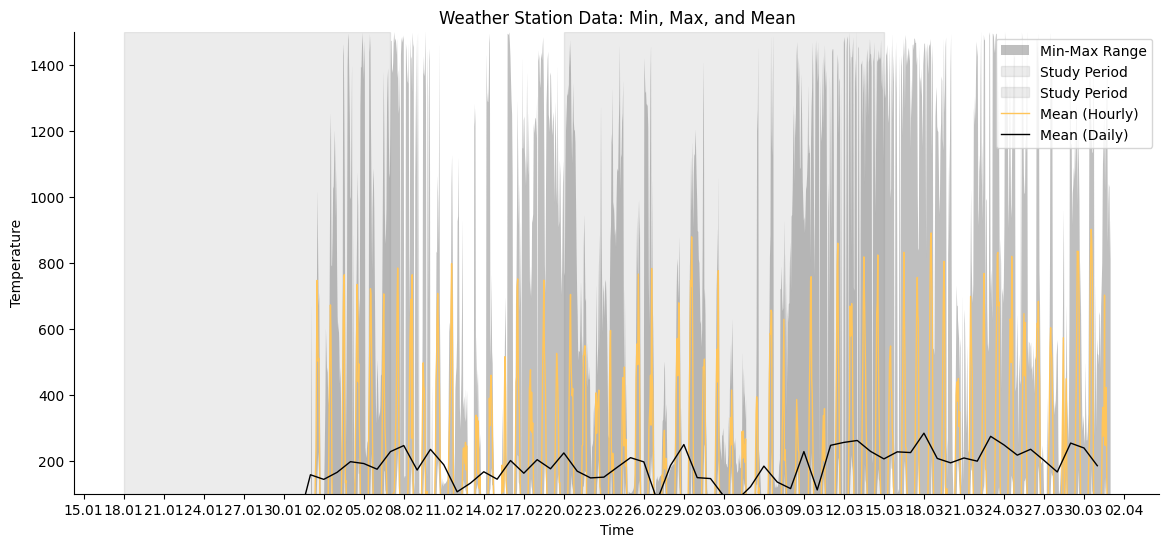

In [66]:
plot_weather_station_data(WS_Temp_df, filepath_dir, "Linechart_AirTemperature.png", color_vulcanfire, 22.5, 40)

plot_weather_station_data(WS_relH_df, filepath_dir, "Linechart_RelHumidity.png", cBlue, 20, 100)
plot_weather_station_data(WS_Rad_df, filepath_dir, "Linechart_RelHumidity.png", cYellow, 100, 1500)

C:\Users\gottk\AppData\Local\Temp\ipykernel_16304\1931919520.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\gottk\AppData\Local\Temp\ipykernel_16304\1931919520.py:80: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\Boxchart_AirTemperaturewithTotalValues_Day.png


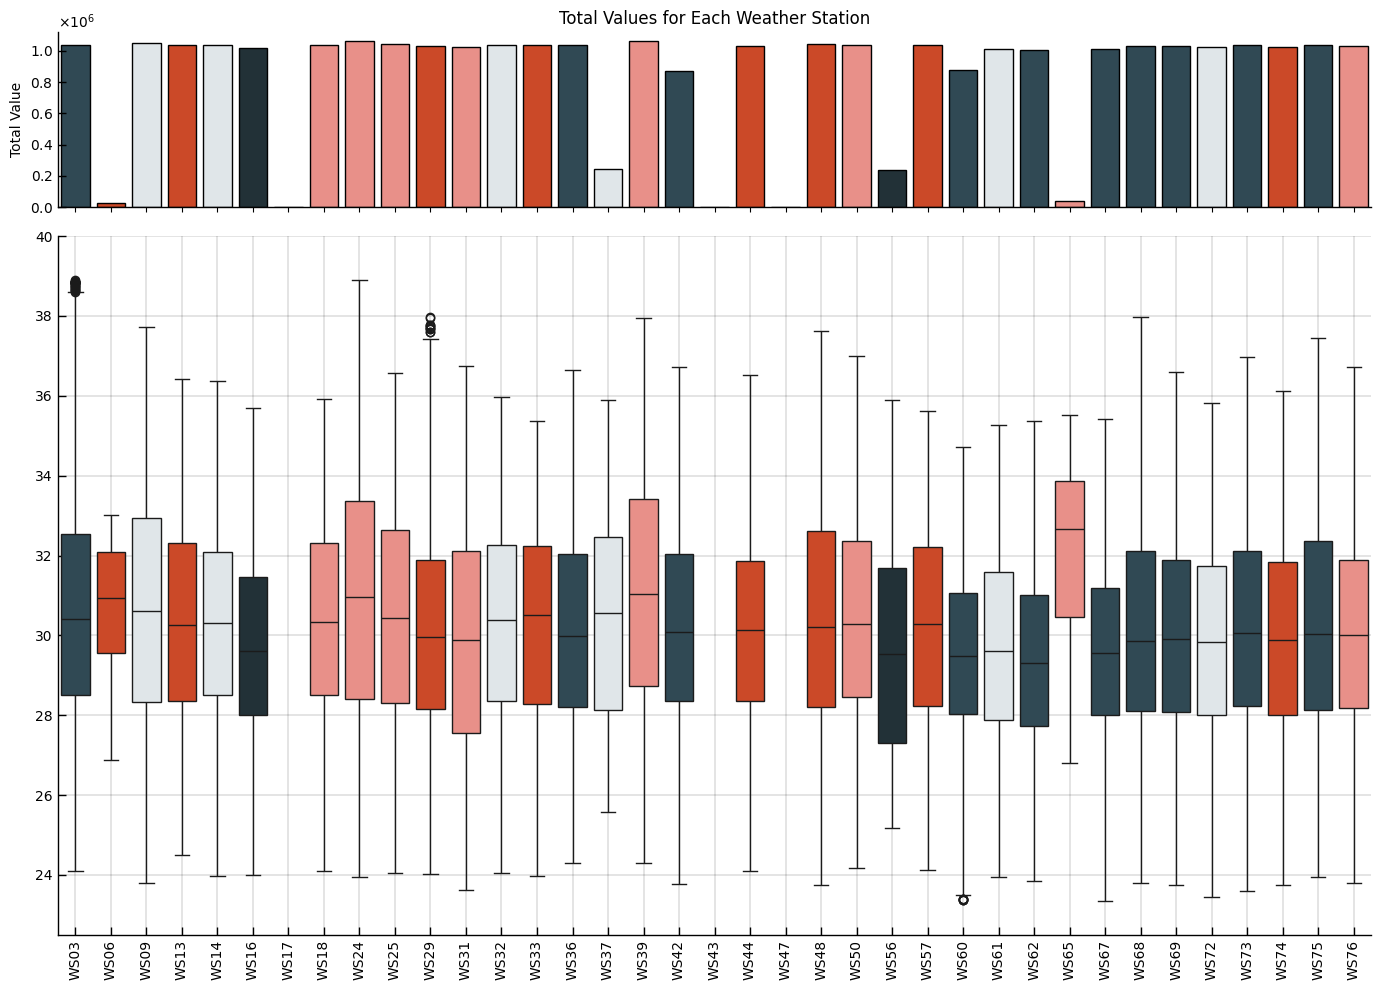

In [67]:
# -------------------------------------------------------------------------------------------
# Plot the boxplots
#
# -------------------------------------------------------------------------------------------

# Assume color_citylights, color_coralpink, color_vulcanfire, color_deepseablue, and color_elderberryblack are predefined color values.

# Create the cluster info DataFrame
# WS_Temp_filtered_df.index = pd.to_datetime(WS_Temp_filtered_df.index)

# Filter based on the hour
filtered_df = WS_Temp_filtered_df[(WS_Temp_filtered_df.index.hour > 7) & (WS_Temp_filtered_df.index.hour < 21)]

# Optionally rename columns
filtered_df.columns = [col.split('_')[0] for col in filtered_df.columns]

df = filtered_df
# Create a dictionary for the cluster values
cluster_dict = dict(zip(withCluster_WS_df['Shortname'], withCluster_WS_df['Cluster']))

# Predefined color map for clusters
predefined_colors = {0: color_citylights, 1: color_coralpink, 2: color_vulcanfire, 3: color_deepseablue, 4: color_elderberryblack}

# Generate a color palette with distinct colors for each unique cluster
unique_clusters = sorted(set(cluster_dict.values()))
palette = sns.color_palette("husl", len(unique_clusters))
color_map = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}

# Update the color map with predefined colors
color_map.update(predefined_colors)

# Map colors to the columns in the DataFrame based on the cluster
column_colors = [color_map[cluster_dict.get(col, 0)] for col in df.columns]

# Calculate total values
total_values = df.sum()

# Create subplots
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 4]})

# Bar plot on the first axis
bar = sns.barplot(x=total_values.index, y=total_values.values, ax=ax1, palette=column_colors)

# Customize bar plot aesthetics
ax1.set_title('Total Values for Each Weather Station')
ax1.set_ylabel('Total Value')
ax1.set_facecolor('white')
ax1.set_xticklabels([])  # Remove x-tick labels
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(1)
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_linewidth(1)
ax1.spines['left'].set_color('black')
ax1.tick_params(axis='y', direction='in', length=6, width=1, colors='black')

ax1.set_xlabel('')

# Add black outline to bars
for patch in ax1.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1)  # Set black outline

ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Box plot on the second axis
box = sns.boxplot(data=df, ax=ax2, palette=column_colors)

# Apply colors to the boxplot elements and set transparency
for i, patch in enumerate(box.artists):
    patch.set_facecolor(column_colors[i])
    patch.set_edgecolor('black')
    patch.set_alpha(1)

# Customize box plot aesthetics
#ax2.set_title('Boxplots of Each Column')
ax2.set_ylim(22.5, 40)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_facecolor('white')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_linewidth(1)
ax2.spines['bottom'].set_color('black')
ax2.spines['left'].set_linewidth(1)
ax2.spines['left'].set_color('black')
fig.set_facecolor('white')
ax2.tick_params(axis='both', which='both', direction='in', length=6, width=1, colors='black')
ax2.grid(True, which='both', axis='both', color='black', linestyle='-', linewidth=0.15)

# Adjust layout
plt.tight_layout()

# Show the plot
filepath = os.path.join(filepath_dir, "Boxchart_AirTemperaturewithTotalValues_Day.png")
if filepath != "":
    directory = os.path.dirname(filepath)
        
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
    print(f"Plot saved to {filepath}")

plt.show()



What do i need?

A Boxplot for each weather station, average, time of the day (night and day) and a linechart for the temperature path during the study
-- > this for each weatherstation as a layout plot

plot per average minute values, mazbe cluster the differnte stations based on environment

### Weather Data Analysis from Weather stations

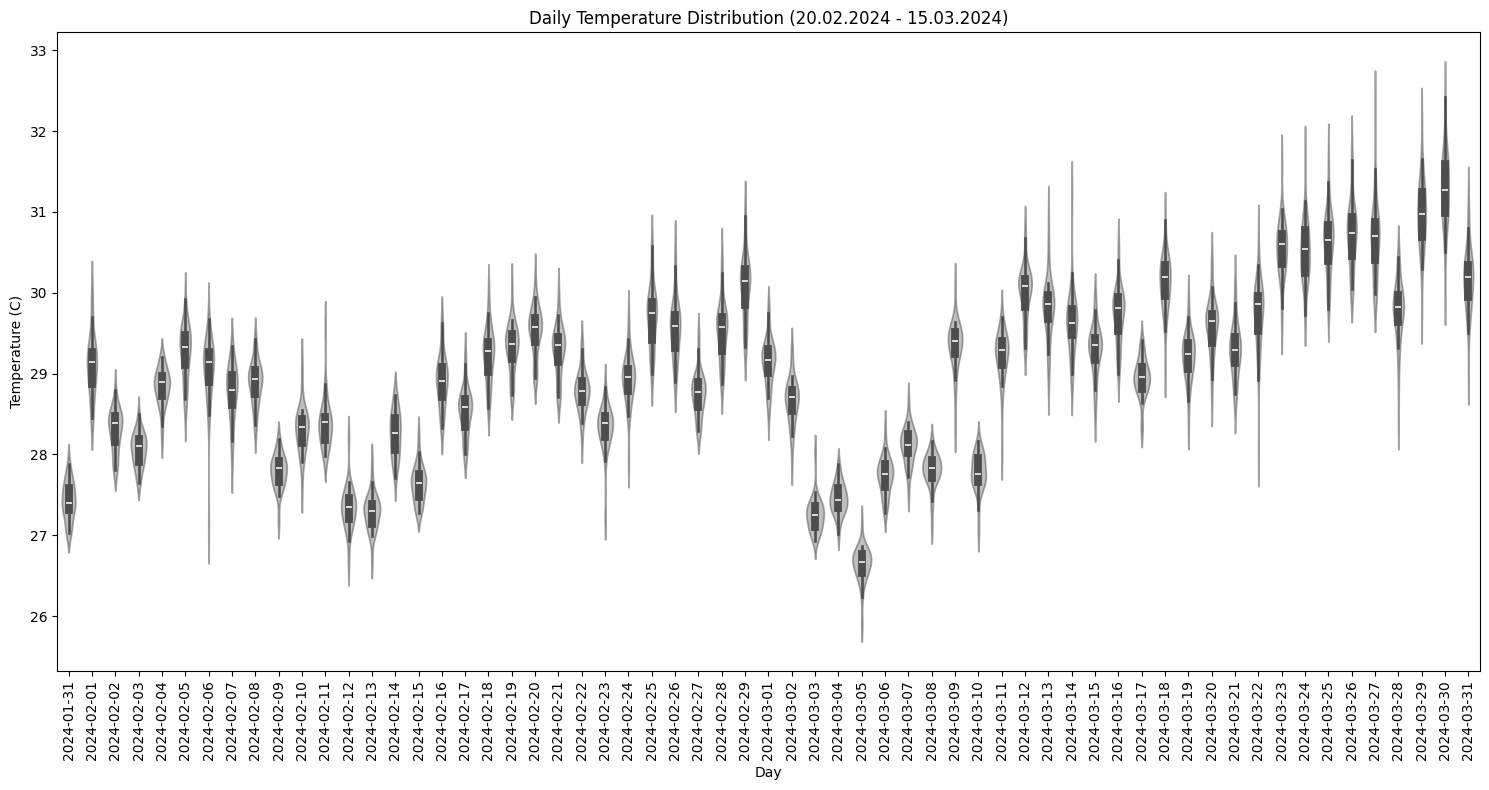

In [81]:
# # Filter data for the specific date range
# start_date = '2024-01-01'
# end_date = '2024-03-20'
# filtered_df = WS_Temp_df.loc[start_date:end_date]

# Resample the data to daily intervals
WS_Temp_df_daily = WS_Temp_df.resample('D').mean()

# Reset index to have 'Datetime' as a column for easier manipulation
WS_Temp_df_daily.reset_index(inplace=True)

# Melt the dataframe to long format for seaborn
WS_Temp_long = WS_Temp_df_daily.melt(id_vars=['Datetime'], var_name='Station', value_name='Temperature')

# Extract day from Datetime for plotting
WS_Temp_long['Day'] = WS_Temp_long['Datetime'].dt.date

# Plot the data
plt.figure(figsize=(15, 8))
sns.violinplot(x='Day', y='Temperature', data=WS_Temp_long, inner='box', color='grey', alpha=0.5)

plt.xticks(rotation=90)
plt.title('Daily Temperature Distribution (20.02.2024 - 15.03.2024)')
plt.xlabel('Day')
plt.ylabel('Temperature (C)')
plt.tight_layout()
plt.show()

## Regression Kriging


In [ ]:
#TODO!
#analyse the weather station data
#How to do the krigign, check the gps data, what are the time differences


#Get the participant Data local and filter out the relevenat dates and times by 5min increments?
#Create a plot, how much time on average on runs between Locations points, this is the base fro the interpolation
#Combine all weather data into one df
#Take from the pool the relevant data and create the waetherdatafiles for the regression
#Analysie the temperatrue data in a linechart plot


# Directory Definitions
parent_dir: str = 'C:/Users/gottk/OneDrive/GITHUB/calma-esse-heat-stress-internal/Esse/data/krigging/'
dirWH: str = os.path.join(parent_dir, 'Weatherdata')
dirOut: str = r'Esse\report\krigging_output'

# File Definitions
griddf    = pd.read_csv(parent_dir + '5mGrid_features_original.csv').fillna(0)
wsdf      = pd.read_csv(parent_dir + 'WS_features.csv').fillna(0)

# plttitle = 'RegressionKriging'
today = dt.datetime.now().strftime("%m%d%y-%H%M")
print(today)


#Load Files and make a feature selection
#Feature selection
terrain_features  = ['Ter_height']
sky_features      = ['Sun_h', 'Bld_SkyEx', 'Veg_SkyEx']
bld_features      = ['Bld_percent', 'Bld_height']
veg_features      = ['Veg_height', 'Veg_percent']
distance_features = ['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad',  'distToPath', 'distToCourtTrack', 'distToCarpark']

features = distance_features + sky_features   + veg_features  + bld_features + terrain_features

display(griddf.head())
display(wsdf.head())
print(features)

### Get the Weather Data to interpolate
This loads the feature data.
Currently Available:


1. 'Tavg' Temperature
2. 'Radavg" Radiation (not yet)
3. 'Havg' Humidity (not yet)
4. 'Wsavg' Windspeed (not yet)
5. 'Wdavg' Winddirection (not yet)



In [ ]:
### Specify temperature measure to use
measure = "TAvg" # options: ['Tmax','Tavg']

### Read and prepare weather data
df = pd.read_csv(dirWH + '/' + measure +'.csv')
df = df.merge(wsdf[["X","Y",'ID']], on='ID', how='left')

### Get min and max value for plotting graph
minval = df.drop(columns=['ID','Lat','Long','X','Y']).min(numeric_only=True).min()
maxval = df.drop(columns=['ID','Lat','Long','X','Y']).max(numeric_only=True).max()
print("Min: ", minval, "Max: ",maxval)

display(df)

### Clustering

In [ ]:
metadatadf = griddf.copy()

# Quantization function
def quantize_column(column, step_size):
    return round(column / step_size) * step_size

# Number of steps for quantization
num_steps = 3

feature_list = ['Bld_percent', 'distToBuilding', 'Bld_height', 'Veg_height', 'distToTree']


# Determine step sizes for each column and apply quantization
for col in feature_list:
    step_size = metadatadf[col].max() / num_steps
    metadatadf[f'quantized_{col}'] = metadatadf[col].apply(quantize_column, args=(step_size,))

# Standard scaling
scaler = StandardScaler()
metadatadf[feature_list] = scaler.fit_transform(metadatadf[feature_list])

# KMeans clustering
n_clusters = 10
metadatadf['cluster'] = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(metadatadf[feature_list])

# Plot the clustered data
plt.scatter(metadatadf['X'], metadatadf['Y'], c=metadatadf['cluster'], cmap='rainbow', s=1, marker='s')
plt.title('Clustered Data')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.colorbar(label='Cluster')
plt.show()
#-------------------------------------------------------------------------------------------------
# DBSCAN clustering
X = metadatadf[['cluster', 'X', 'Y']] #features for DBclustering
X_scaled = StandardScaler().fit_transform(X)

eps = 0.35
min_samples = 250
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
metadatadf['cluster'] = dbscan.fit_predict(X_scaled)

# Visualize the DBSCAN clustering
plt.scatter(metadatadf['X'], metadatadf['Y'], c=metadatadf['cluster'], cmap='hsv', s=1, marker='s')
plt.colorbar(label='Cluster')
plt.title('DBSCAN Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

#-------------------------------------------------------------------------------------------------
#downsampling and upscaling again
# Group by the cluster column
metadata_df_grp = metadatadf.groupby('cluster')

# Define a function to sample a specific percentage from each group
def downsample_group(group):
    return group.sample(frac=0.25)  # You can adjust the fraction as needed

# Apply the downsampling function to each group
downsampled_df = metadata_df_grp.apply(downsample_group)

# Reset the index of the downsampled DataFrame
downsampled_df.reset_index(drop=True, inplace=True)

plt.scatter(downsampled_df['X'], downsampled_df['Y'], c=downsampled_df['cluster'], cmap='hsv', alpha=0.7,  s=5, marker='s')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Downsampled Scatter Plot')

# Add a colorbar to show the cluster information
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

# Show the plot
plt.show()

# Fit Nearest Neighbors model on the downsampled data
nn_model = NearestNeighbors(n_neighbors=1).fit(downsampled_df[['X', 'Y']])

# Find the index of the nearest neighbor for each point in griddf
distances, indices = nn_model.kneighbors(griddf[['X', 'Y']])

# Map the cluster values from downsampled_df to griddf based on the nearest neighbors
griddf['cluster'] = downsampled_df.loc[indices.flatten()]['cluster'].values

plt.scatter(griddf['X'], griddf['Y'], c=griddf['cluster'], cmap='viridis', alpha=0.7,  s=1, marker='s')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot with Cluster Test')

# Add a colorbar to show the cluster information
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

# Show the plot
plt.show()

#-------------------------------------------------------------------------------------------------
#Somehow smooth the data..



#-------------------------------------------------------------------------------------------------
#adjusting the considered features
quantized_cols = metadatadf.filter(like='quantized').columns
# griddf = metadatadf.drop(columns=quantized_cols) #.drop(columns=['cluster_x', 'cluster_y'])

features.append('cluster')

### get features for wsdf
# Calculating distances using sklearn's NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(griddf[['X', 'Y']])
distances, indices = nbrs.kneighbors(wsdf[['X', 'Y']])
# Add the index of the closest point in griddf to wsdf
wsdf['closest_index'] = indices.flatten()
# Retrieve specific columns from griddf based on closest_index and merge it with wsdf and only new selection features
merged_data = wsdf.join(griddf['cluster'], on='closest_index') #rsuffix='_griddf')
# Drop the redundant 'closest_index' column
wsdf = merged_data.drop(columns=['closest_index'])


# Print the updated list
print(features)

#display(griddf)


### Regression Kriging

In [ ]:
### Select features for model
p = wsdf[features]
target_p = griddf[features]
target_x = np.array(list(zip(griddf.X, griddf.Y)))

feature_importance_df = pd.DataFrame(features, columns =['FeatureName'])

### SVR model parameters
C = 0.0005
gamma = 5
kernel = ['linear'] # options: ['#linear', 'poly', 'rbf', 'sigmoid']

### RandomForestRegressor parameters
n_estimators=50
random_state=4

### RegressionKrigging parameters
n = 8
variogram_models = ['spherical'] # options: ["linear", "power", "gaussian", "spherical", "exponential"]

### List of month names
months = ["Feb-19"] # "Mar-19","Apr-19","May-19","Jun-19","Jul-19","Aug-19","Sep-19","Oct-19","Nov-19","Dec-19","Jan-20","Feb-20","Mar-20","Apr-20"


for k in variogram_models:
    model = RandomForestRegressor(n_estimators=15, random_state=random_state)

    scores_mths = []
    for mth in months:
        print(mth)

        x = np.array(list(zip(wsdf.X, wsdf.Y)))
        target = np.array(df[mth])

        print("=" * 40)
        m_rk = RegressionKriging(regression_model=model, n_closest_points=n, variogram_model=k, verbose=False)

        m_rk.fit(p, x, target)
        result = m_rk.predict(target_p, target_x)
        resultdf = griddf
        resultdf[measure] = result

        ### Plot map (uncomment and adjust vmin, vmax and ticks if needed)
        plt.figure(figsize=(10, 7))
        plt.scatter(resultdf['X'], resultdf['Y'], c=resultdf[measure], cmap='seismic', marker='s', s=1, vmin=minval, vmax=maxval)
        plt.title('Scatter plot of '+ measure +' (' + mth + ')')
        cbar = plt.colorbar()
        # ticks = [14.0,16.5,19.0,21.5,24.0,26.5,29.0,31.5]
        # cbar.set_ticks(ticks)
        # cbar.set_ticklabels(ticks)

        ### Print results to csv per month (uncomment to save csv and png)
        if not os.path.exists(dirOut + today):
          os.makedirs(dirOut + today)
        resultdf.to_csv(dirOut + today + '/' + measure + mth + '.csv')
        plt.savefig(dirOut + today + '/' + measure + mth + '.png', bbox_inches='tight')
        plt.show()

        ### Extract feature importances (uncomment to display feature importances)
        feature_importance_df[mth] = m_rk.regression_model.feature_importances_
        # featuredf = pd.DataFrame(list(zip(m_rk.regression_model.feature_names_in_, m_rk.regression_model.feature_importances_)), columns =['FeatureName', 'FeatureImportance'])
        # display(featuredf.sort_values(by=['FeatureImportance'], ascending=False))

### Feature Importance

In [ ]:
feature_importance_df = feature_importance_df.assign(mean=feature_importance_df.mean(axis=1))

feature_plotheatmap = feature_importance_df.sort_values(by=['mean'], ascending=False)
feature_plotheatmap = feature_plotheatmap.set_index('FeatureName')

plt.figure(figsize=(10, 6))
sns.heatmap(feature_plotheatmap, annot=True, cmap='coolwarm')
plt.title('Feature Importance Heatmap')
plt.xlabel('Models')
plt.ylabel('Features')
plt.show()

# plt.savefig(dirRP + today + '/' + 'FeatureMap' + '_' + measure + mth + '.png', bbox_inches='tight')

#select features based on threshhold
treshhold = 0.025
update_feature_selection = feature_plotheatmap[feature_plotheatmap['mean'] > treshhold].index.tolist()
print(update_feature_selection)